In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '54-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
# import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [30]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": int(128 /2),
  "EPOCHS": 12,
  "LEARNING_RATE": 3e-4 /2,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 64,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 12,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.00015,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'WIDTH': 256}

# Load data

In [15]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-65548a4c87d02212371fce6e9bd762100c34bf9b9ebbd04b0dd4b65b'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [16]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .6:
        if p_spatial2 >= .9:
            image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'], 180.)
        elif p_spatial2 >= .8:
            image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'], 8., 8.)
        elif p_spatial2 >= .7:
            image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'], 8., 8.)
        else:
            image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'], 2.)
        
    if p_crop >= .6: # crops
        if p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    if p_pixel >= .6: # Pixel-level transforms
        if p_pixel >= .9:
            image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
        elif p_pixel >= .8:
            image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
        elif p_pixel >= .7:
            image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
        else:
            image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)

    return image, label

## Auxiliary functions

In [17]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.normal([1],dtype='float32') 
    width_shift = w_shift * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height, h_zoom, w_zoom):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/h_zoom
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/w_zoom
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.00015 to 3.93e-05


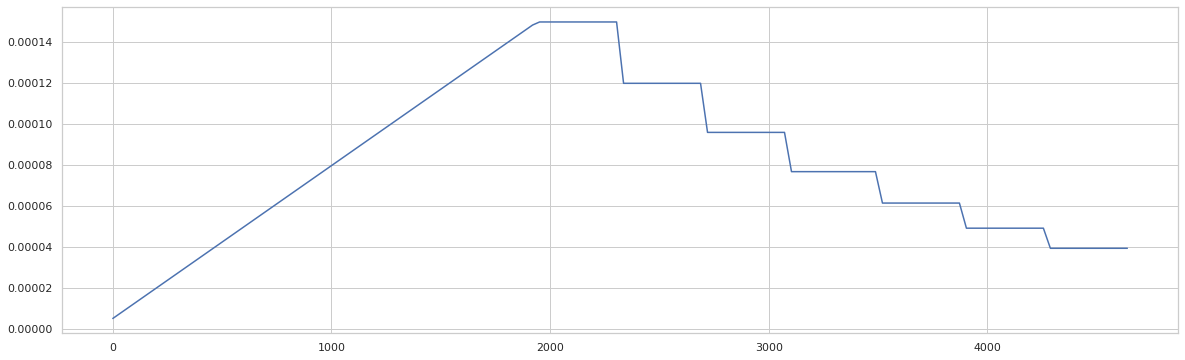

In [31]:
#@title
lr_min = 1e-6
lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .8
step_size = steps_per_epoch * 1

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [32]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [33]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)

NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.28.34.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.28.34.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
388/388 - 47s - auc: 0.5687 - loss: 0.2988 - val_auc: 0.7613 - val_loss: 0.1733
Epoch 2/12
388/388 - 37s - auc: 0.7916 - loss: 0.1692 - val_auc: 0.8052 - val_loss: 0.1679
Epoch 3/12
388/388 - 37s - auc: 0.8314 - loss: 0.1692 - val_auc: 0.8316 - val_loss: 0.1671
Epoch 4/12
388/388 - 35s - auc: 0.8430 - loss: 0.1672 - val_auc: 0.8580 - val_loss: 0.1675
Epoch 5/12
388/388 - 37s - auc: 0.8334 - loss: 0.1656 - val_auc: 0.8027 - val_loss: 0.1657
Epoch 6/12
388/388 - 36s - auc: 0.8595 - loss: 0.1663 - val_auc: 0.8599 - val_loss: 0.1644
Epoch 7/12
388/388 - 35s - auc: 0.8784 - loss: 0.1634 - val_auc: 0.8570 - val_loss: 0.1648
Epoch 8/12
388/388 - 37s - auc: 0.8884 - loss: 0.1620 - val_auc: 0.8680 - val_loss: 0.1631
Epoch 9/12
388/388 - 37s - auc: 0.9047 - loss: 0.1607 - val_auc: 0.8588 - val_loss: 0.1626
Epoch 10/12
388/388 - 35s - auc: 0.9163 - loss: 0.1591 - val_auc: 0.8452 - val_loss: 0.1634
Epoch 11/12
388/388 - 35s - auc: 0.9253 - loss: 0.1571 - val_auc: 0.8699 - val_loss: 0.16

INFO:tensorflow:Initializing the TPU system: grpc://10.28.34.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.28.34.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
420/420 - 49s - auc: 0.5738 - loss: 0.3210 - val_auc: 0.7983 - val_loss: 0.1705
Epoch 2/12
420/420 - 39s - auc: 0.7921 - loss: 0.1702 - val_auc: 0.8459 - val_loss: 0.1673
Epoch 3/12
420/420 - 39s - auc: 0.8276 - loss: 0.1669 - val_auc: 0.8155 - val_loss: 0.1671
Epoch 4/12
420/420 - 39s - auc: 0.8521 - loss: 0.1681 - val_auc: 0.8052 - val_loss: 0.1671
Epoch 5/12
420/420 - 37s - auc: 0.8582 - loss: 0.1651 - val_auc: 0.7981 - val_loss: 0.1697
Epoch 6/12
420/420 - 38s - auc: 0.8585 - loss: 0.1645 - val_auc: 0.8425 - val_loss: 0.1636
Epoch 7/12
420/420 - 38s - auc: 0.8939 - loss: 0.1625 - val_auc: 0.8886 - val_loss: 0.1626
Epoch 8/12
420/420 - 38s - auc: 0.8937 - loss: 0.1618 - val_auc: 0.8695 - val_loss: 0.1614
Epoch 9/12
420/420 - 38s - auc: 0.9176 - loss: 0.1595 - val_auc: 0.8746 - val_loss: 0.1611
Epoch 10/12
420/420 - 39s - auc: 0.9149 - loss: 0.1589 - val_auc: 0.8764 - val_loss: 0.1610
Epoch 11/12
420/420 - 39s - auc: 0.9139 - loss: 0.1574 - val_auc: 0.8761 - val_loss: 0.16

INFO:tensorflow:Initializing the TPU system: grpc://10.28.34.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.28.34.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
420/420 - 49s - auc: 0.5620 - loss: 0.2940 - val_auc: 0.7924 - val_loss: 0.1737
Epoch 2/12
420/420 - 38s - auc: 0.8042 - loss: 0.1690 - val_auc: 0.8298 - val_loss: 0.1691
Epoch 3/12
420/420 - 37s - auc: 0.8415 - loss: 0.1665 - val_auc: 0.8044 - val_loss: 0.1693
Epoch 4/12
420/420 - 38s - auc: 0.8397 - loss: 0.1670 - val_auc: 0.8158 - val_loss: 0.1690
Epoch 5/12
420/420 - 39s - auc: 0.8573 - loss: 0.1653 - val_auc: 0.8343 - val_loss: 0.1673
Epoch 6/12
420/420 - 39s - auc: 0.8821 - loss: 0.1637 - val_auc: 0.8329 - val_loss: 0.1643
Epoch 7/12
420/420 - 38s - auc: 0.8843 - loss: 0.1620 - val_auc: 0.8602 - val_loss: 0.1637
Epoch 8/12
420/420 - 38s - auc: 0.9039 - loss: 0.1602 - val_auc: 0.8570 - val_loss: 0.1629
Epoch 9/12
420/420 - 36s - auc: 0.9097 - loss: 0.1594 - val_auc: 0.8764 - val_loss: 0.1629
Epoch 10/12
420/420 - 37s - auc: 0.9200 - loss: 0.1572 - val_auc: 0.8336 - val_loss: 0.1630
Epoch 11/12
420/420 - 43s - auc: 0.9310 - loss: 0.1553 - val_auc: 0.8169 - val_loss: 0.16

INFO:tensorflow:Initializing the TPU system: grpc://10.28.34.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.28.34.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
420/420 - 45s - auc: 0.5693 - loss: 0.3167 - val_auc: 0.7656 - val_loss: 0.1729
Epoch 2/12
420/420 - 38s - auc: 0.7962 - loss: 0.1690 - val_auc: 0.8551 - val_loss: 0.1686
Epoch 3/12
420/420 - 38s - auc: 0.8228 - loss: 0.1682 - val_auc: 0.8465 - val_loss: 0.1682
Epoch 4/12
420/420 - 39s - auc: 0.8470 - loss: 0.1652 - val_auc: 0.8627 - val_loss: 0.1675
Epoch 5/12
420/420 - 37s - auc: 0.8543 - loss: 0.1652 - val_auc: 0.8131 - val_loss: 0.1693
Epoch 6/12
420/420 - 38s - auc: 0.8766 - loss: 0.1645 - val_auc: 0.8507 - val_loss: 0.1652
Epoch 7/12
420/420 - 36s - auc: 0.8953 - loss: 0.1625 - val_auc: 0.8656 - val_loss: 0.1653
Epoch 8/12
420/420 - 37s - auc: 0.9117 - loss: 0.1598 - val_auc: 0.8537 - val_loss: 0.1666
Epoch 9/12
420/420 - 38s - auc: 0.9186 - loss: 0.1587 - val_auc: 0.8644 - val_loss: 0.1642
Epoch 10/12
420/420 - 36s - auc: 0.9248 - loss: 0.1582 - val_auc: 0.8493 - val_loss: 0.1643
Epoch 11/12
420/420 - 37s - auc: 0.9292 - loss: 0.1569 - val_auc: 0.8509 - val_loss: 0.16

INFO:tensorflow:Initializing the TPU system: grpc://10.28.34.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.28.34.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
420/420 - 49s - auc: 0.5716 - loss: 0.3218 - val_auc: 0.8143 - val_loss: 0.1692
Epoch 2/12
420/420 - 38s - auc: 0.7945 - loss: 0.1703 - val_auc: 0.8596 - val_loss: 0.1664
Epoch 3/12
420/420 - 38s - auc: 0.8332 - loss: 0.1679 - val_auc: 0.8563 - val_loss: 0.1661
Epoch 4/12
420/420 - 38s - auc: 0.8433 - loss: 0.1668 - val_auc: 0.8713 - val_loss: 0.1647
Epoch 5/12
420/420 - 37s - auc: 0.8621 - loss: 0.1664 - val_auc: 0.8594 - val_loss: 0.1656
Epoch 6/12
420/420 - 38s - auc: 0.8688 - loss: 0.1644 - val_auc: 0.8851 - val_loss: 0.1633
Epoch 7/12
420/420 - 38s - auc: 0.8839 - loss: 0.1627 - val_auc: 0.8760 - val_loss: 0.1624
Epoch 8/12
420/420 - 38s - auc: 0.9051 - loss: 0.1605 - val_auc: 0.9016 - val_loss: 0.1602
Epoch 9/12
420/420 - 38s - auc: 0.9064 - loss: 0.1600 - val_auc: 0.8982 - val_loss: 0.1601
Epoch 10/12
420/420 - 38s - auc: 0.9217 - loss: 0.1575 - val_auc: 0.8852 - val_loss: 0.1599
Epoch 11/12
420/420 - 39s - auc: 0.9250 - loss: 0.1566 - val_auc: 0.8648 - val_loss: 0.15

## Model loss graph

Fold: 1


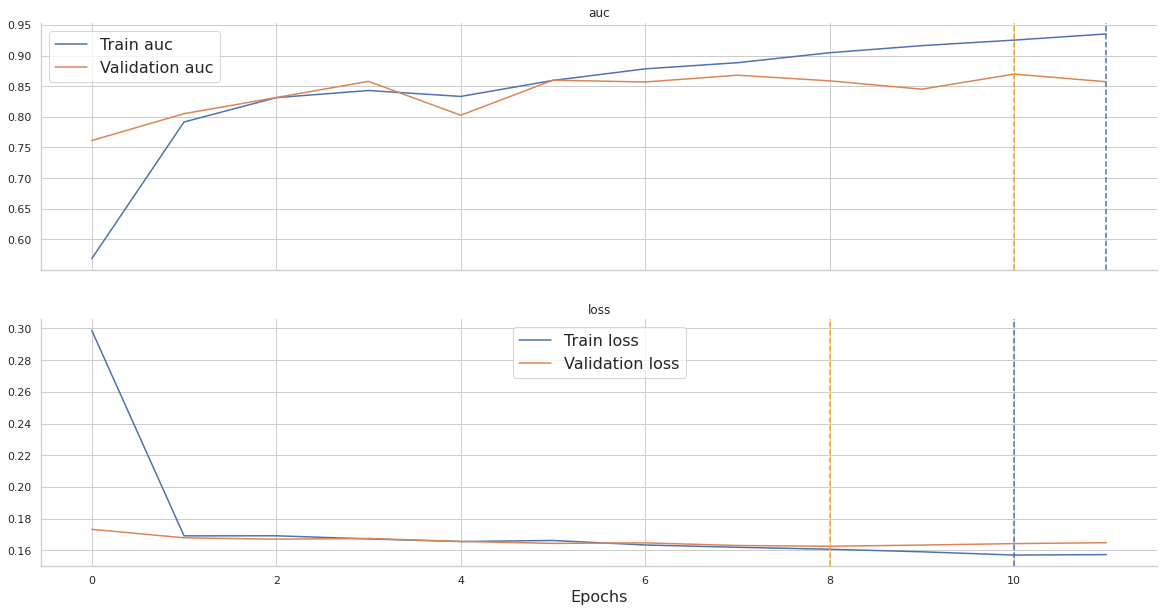

Fold: 2


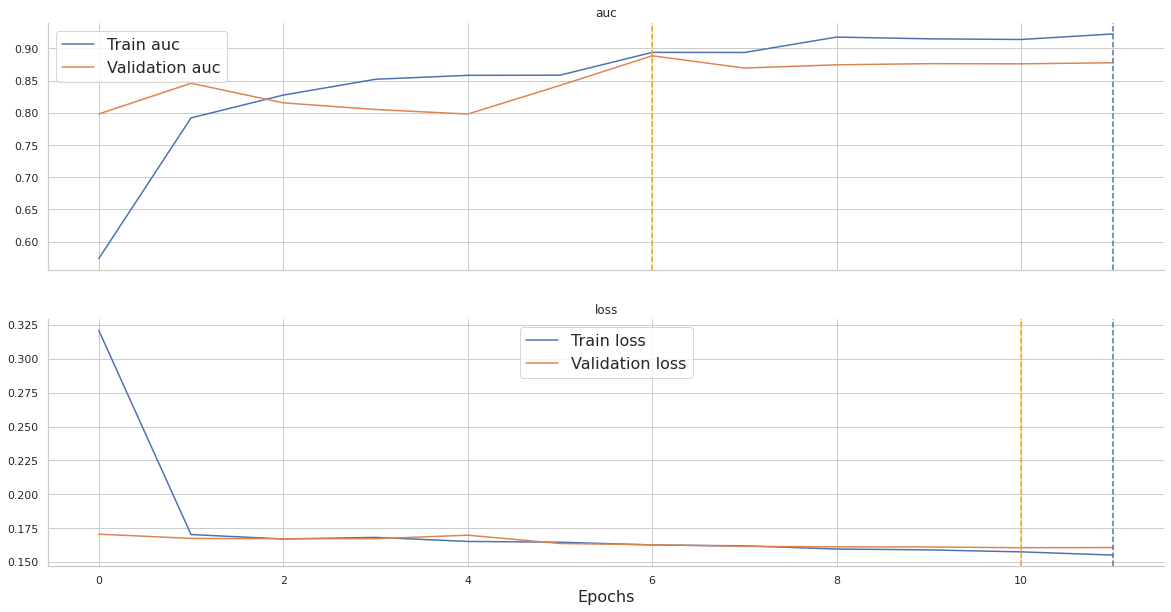

Fold: 3


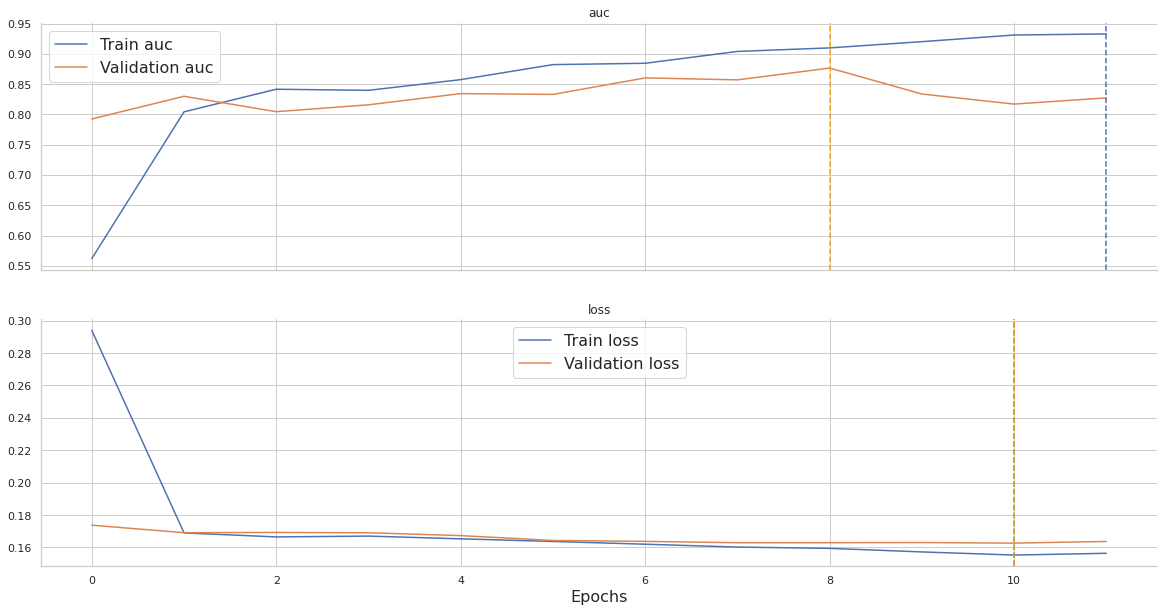

Fold: 4


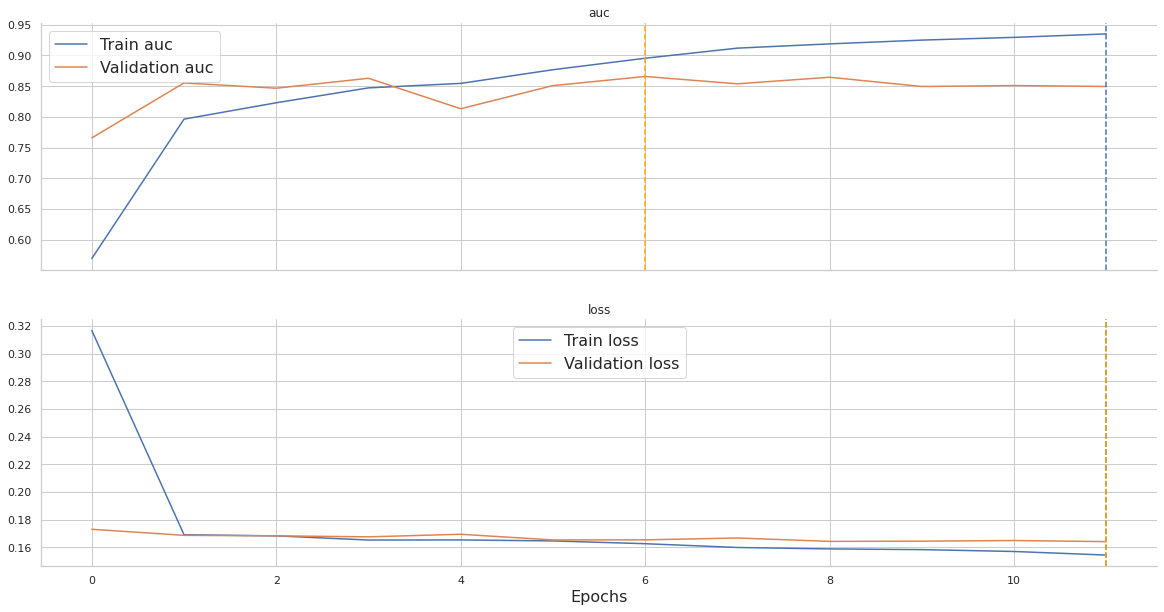

Fold: 5


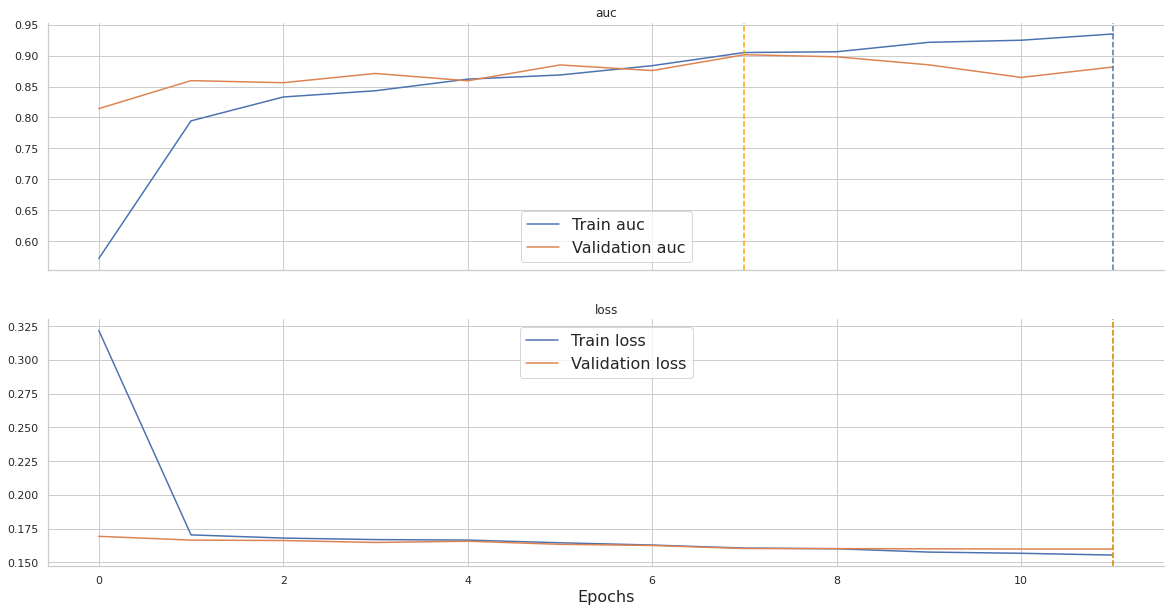

In [34]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

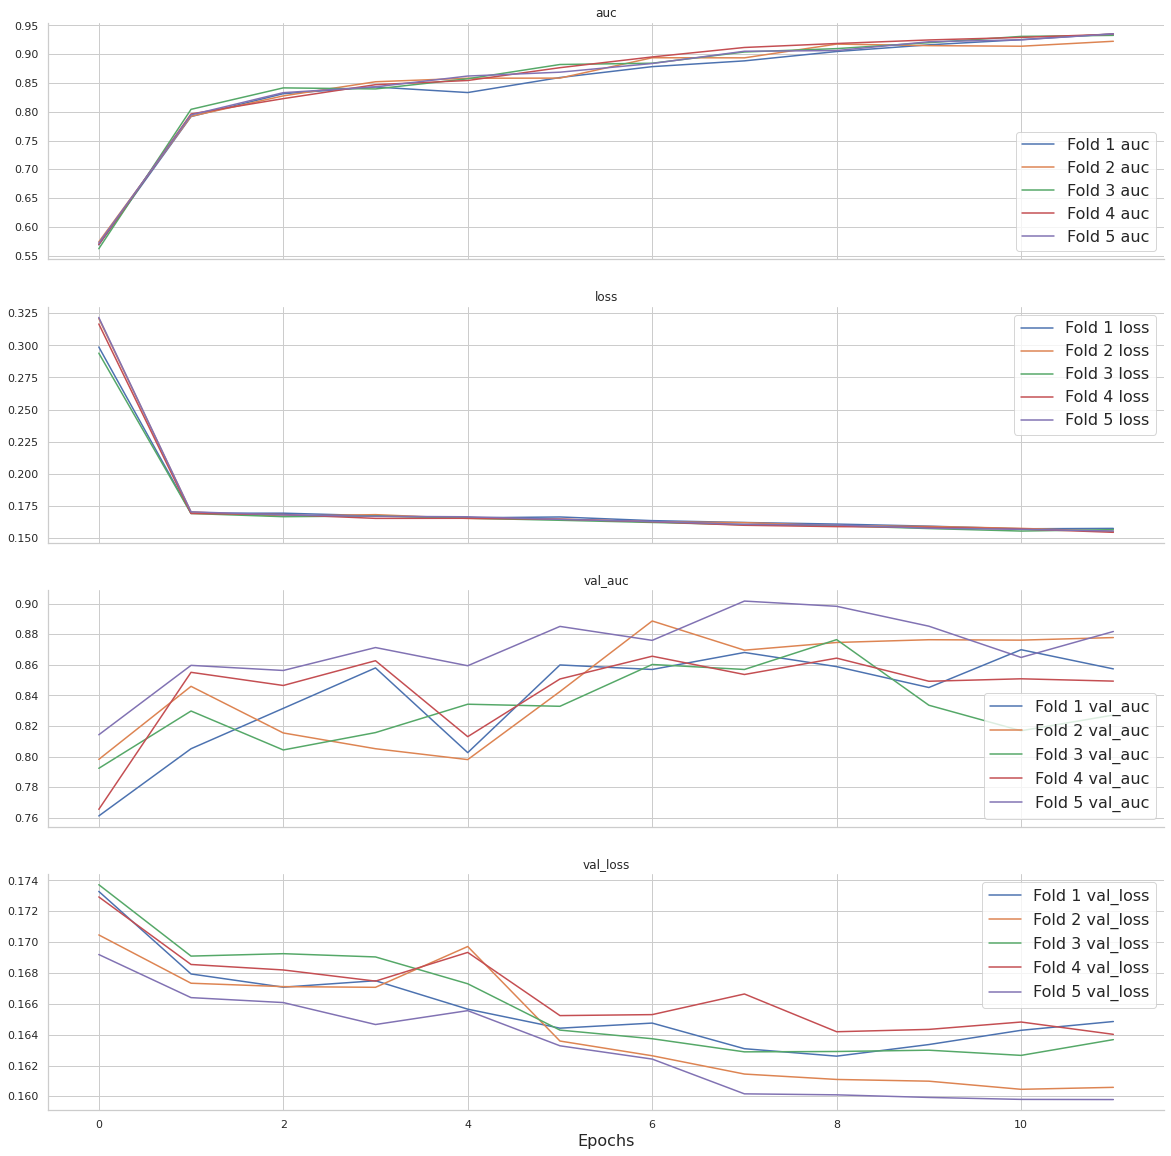

In [35]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [36]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.968953,0.863256,0.105697,0.962561,0.859705,0.966584,0.877974,0.971072,0.835046,0.971410,0.853919,0.973134,0.889635
Accuracy,0.986979,0.982185,0.004794,0.986797,0.981289,0.986735,0.982134,0.987144,0.982617,0.986963,0.981783,0.987255,0.983100
Precision,0.785992,0.485783,0.300209,0.783251,0.340909,0.800000,0.485714,0.761506,0.580645,0.837989,0.476190,0.747212,0.545455
Recall,0.362902,0.135235,0.227667,0.358916,0.106383,0.329114,0.154545,0.386412,0.159292,0.317797,0.089286,0.422269,0.166667
F1-score,0.494346,0.210468,0.283878,0.492260,0.162162,0.466368,0.234483,0.512676,0.250000,0.460829,0.150376,0.539597,0.255319
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


# Model evaluation by Subset

In [37]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.968953,0.863256,0.105697,0.962561,0.859705,0.966584,0.877974,0.971072,0.835046,0.971410,0.853919,0.973134,0.889635
male,0.970390,0.867685,0.102705,0.962327,0.872958,0.970376,0.867203,0.972097,0.859548,0.972849,0.838600,0.974299,0.900115
female,0.966021,0.851318,0.114703,0.961212,0.838018,0.960958,0.892079,0.969163,0.777806,0.968199,0.872495,0.970572,0.876190
head/neck,0.960317,0.829166,0.131151,0.932423,0.888605,0.947925,0.788353,0.962266,0.738390,0.983047,0.836173,0.975923,0.894309
upper extremity,0.970233,0.873847,0.096385,0.967195,0.850726,0.971217,0.893673,0.974630,0.845696,0.963534,0.865572,0.974587,0.913571
lower extremity,0.963176,0.797748,0.165428,0.962661,0.779218,0.961159,0.876300,0.960122,0.772801,0.964801,0.772011,0.967138,0.788411
torso,0.972451,0.891014,0.081437,0.967450,0.896687,0.970176,0.911651,0.975361,0.869844,0.975316,0.873019,0.973952,0.903870
0 <= age < 26,0.939267,0.815740,0.123526,0.921053,0.904196,0.942243,0.829466,0.940492,0.791966,0.958751,0.795633,0.933795,0.757440
26 <= age < 40,0.966309,0.858943,0.107366,0.945984,0.930132,0.973868,0.770959,0.979949,0.773149,0.956152,0.868790,0.975592,0.951686


# Model evaluation (best)

In [38]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.965886,0.858830,0.107056,0.951009,0.858027,0.968449,0.874953,0.964735,0.819012,0.971698,0.853220,0.973540,0.888937
Accuracy,0.986560,0.982354,0.004206,0.985186,0.982134,0.986661,0.981812,0.986661,0.983100,0.986926,0.981783,0.987367,0.982939
Precision,0.795018,0.502989,0.292029,0.815126,0.379310,0.772512,0.459459,0.794737,0.666667,0.837079,0.478261,0.755639,0.531250
Recall,0.324277,0.125955,0.198322,0.218962,0.078014,0.343882,0.154545,0.320594,0.141593,0.315678,0.098214,0.422269,0.157407
F1-score,0.455646,0.200020,0.255626,0.345196,0.129412,0.475912,0.231293,0.456884,0.233577,0.458462,0.162963,0.541779,0.242857
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.965886,0.858830,0.107056,0.951009,0.858027,0.968449,0.874953,0.964735,0.819012,0.971698,0.853220,0.973540,0.888937
male,0.968505,0.866384,0.102122,0.954174,0.881098,0.972537,0.856971,0.967635,0.854804,0.973249,0.839313,0.974933,0.899732
female,0.960972,0.841978,0.118994,0.943804,0.820311,0.962426,0.906261,0.959541,0.738752,0.968349,0.869615,0.970742,0.874951
head/neck,0.961856,0.827185,0.134671,0.934562,0.880930,0.957965,0.773577,0.957787,0.755108,0.983123,0.837846,0.975845,0.888465
upper extremity,0.968503,0.875741,0.092762,0.959099,0.854040,0.975124,0.894735,0.968941,0.845620,0.964276,0.869293,0.975076,0.915017
lower extremity,0.958762,0.785203,0.173559,0.946091,0.775165,0.962572,0.861391,0.952847,0.733489,0.964591,0.769293,0.967708,0.786675
torso,0.968327,0.888616,0.079711,0.953789,0.897465,0.969765,0.918722,0.967910,0.851289,0.975750,0.870018,0.974422,0.905585
0 <= age < 26,0.937223,0.790147,0.147075,0.907970,0.884266,0.938047,0.830626,0.944762,0.682254,0.959794,0.799127,0.935540,0.754464
26 <= age < 40,0.966782,0.828855,0.137928,0.960079,0.838923,0.970157,0.772887,0.973345,0.708642,0.955255,0.874868,0.975077,0.948955


# Confusion matrix

Fold: 1


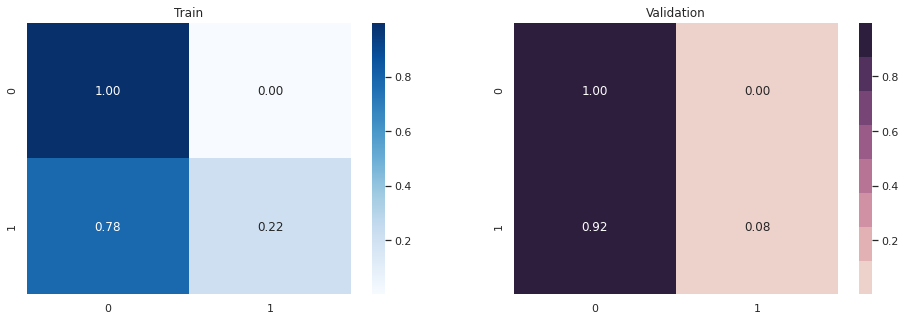

Fold: 2


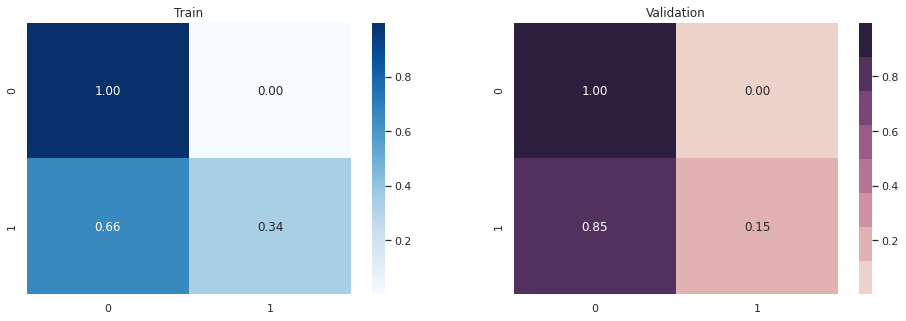

Fold: 3


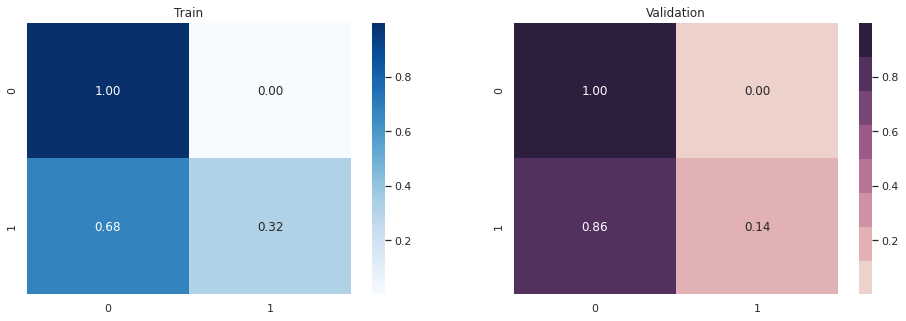

Fold: 4


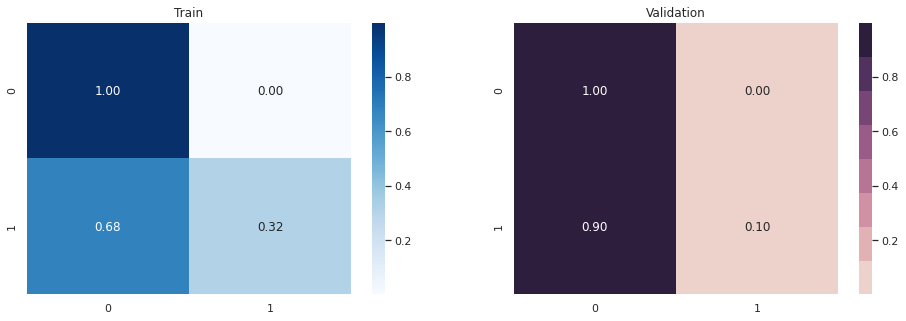

Fold: 5


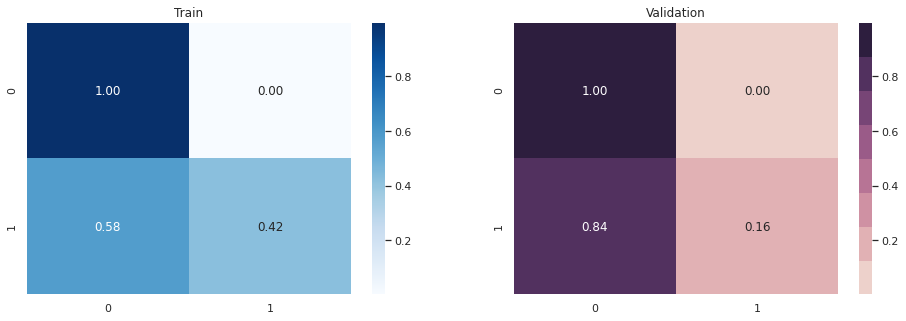

In [39]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [40]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 214
Train positive correct predictions: 178
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.033901,0.016455,0.020561,0.023623,0.061150,0.047715
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.027434,0.024564,0.034368,0.021452,0.020382,0.036404
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.027074,0.026984,0.025505,0.028930,0.030973,0.022977
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.043260,0.052192,0.024876,0.043704,0.045071,0.050456
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.028490,0.024665,0.026760,0.024274,0.029764,0.036987
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.023393,0.024122,0.023326,0.019837,0.020508,0.029174
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.028450,0.010836,0.028290,0.030285,0.032840,0.040002
7,ISIC_0075663,female,35.0,torso,unknown,0,0.024456,0.027687,0.021826,0.025345,0.023595,0.023829
8,ISIC_0075914,male,30.0,torso,unknown,0,0.023182,0.023937,0.019023,0.026080,0.023559,0.023311
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.022839,0.027075,0.023798,0.022907,0.017489,0.022925


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.104243,0.027253,0.077693,0.031106,0.034572,0.350590
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.664024,0.133695,0.799805,0.907833,0.790084,0.688704
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.140845,0.088213,0.176685,0.039445,0.174747,0.225134
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.076816,0.039652,0.077317,0.073201,0.081693,0.112217
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.165173,0.066182,0.163911,0.134868,0.095906,0.364999
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.327457,0.523830,0.397986,0.152365,0.120654,0.442450
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.194758,0.268825,0.080658,0.308002,0.134334,0.181973
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.144511,0.062217,0.119292,0.159820,0.148052,0.233174
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.114449,0.067498,0.081126,0.184301,0.118950,0.120369
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.177494,0.117837,0.511505,0.059608,0.089127,0.109393


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.664024,0.133695,0.799805,0.907833,0.790084,0.688704
707,ISIC_0314462,male,80.0,torso,unknown,0,0.590500,0.651499,0.598753,0.628940,0.398321,0.674988
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.816331,0.947513,0.741291,0.693290,0.741071,0.958489
841,ISIC_0356238,male,70.0,torso,unknown,0,0.681086,0.592413,0.475179,0.693493,0.761585,0.882760
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.517684,0.326646,0.810739,0.348341,0.365198,0.737494
1205,ISIC_0464315,male,70.0,torso,unknown,0,0.635061,0.755707,0.410469,0.892473,0.213793,0.902862
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.864656,0.940051,0.840676,0.983441,0.645617,0.913497
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.850721,0.904583,0.776357,0.778114,0.854686,0.939864
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.677999,0.248082,0.736205,0.838122,0.912140,0.655444
1435,ISIC_0533122,male,75.0,lower extremity,melanoma,1,0.820450,0.932184,0.780115,0.980114,0.481115,0.928721


# Visualize test predictions

In [41]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 48|10934
Test predictions (last) 53|10929
Test predictions (tta) 42|10940
Test predictions (last tta) 49|10933
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.024723,0.022920,0.028730,0.026382
1,ISIC_0052349,male,40.0,lower extremity,0.025756,0.022903,0.024751,0.022581
2,ISIC_0058510,female,55.0,torso,0.027756,0.026037,0.025388,0.023920
3,ISIC_0073313,female,50.0,torso,0.031680,0.029403,0.030311,0.028472
4,ISIC_0073502,female,45.0,lower extremity,0.026213,0.022505,0.044266,0.040483
5,ISIC_0074618,male,50.0,lower extremity,0.029054,0.025846,0.027536,0.025213
6,ISIC_0076801,male,45.0,upper extremity,0.024875,0.021793,0.029220,0.025312
7,ISIC_0077586,male,50.0,lower extremity,0.044804,0.043784,0.047155,0.044560
8,ISIC_0082004,female,45.0,torso,0.036926,0.032166,0.037430,0.036500
9,ISIC_0082785,male,65.0,lower extremity,0.030166,0.028579,0.034137,0.030929


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
42,ISIC_0155983,male,70.0,torso,0.525005,0.525972,0.521440,0.561781
403,ISIC_0481105,male,80.0,torso,0.694183,0.742647,0.643850,0.691999
471,ISIC_0539432,female,45.0,lower extremity,0.501240,0.497513,0.517076,0.535750
552,ISIC_0606244,male,70.0,torso,0.554109,0.571601,0.451232,0.420289
596,ISIC_0637104,female,80.0,torso,0.574863,0.558302,0.593772,0.578997
943,ISIC_0936377,male,65.0,head/neck,0.740143,0.719225,0.693501,0.678129
951,ISIC_0945202,male,45.0,NaN,0.620522,0.682605,0.430983,0.473815
1334,ISIC_1294368,female,35.0,torso,0.570949,0.571535,0.597027,0.606736
1485,ISIC_1429763,male,45.0,head/neck,0.824805,0.906151,0.777168,0.792804
1677,ISIC_1593714,female,50.0,lower extremity,0.876120,0.921931,0.783888,0.842346


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
42,ISIC_0155983,male,70.0,torso,0.525005,0.525972,0.521440,0.561781
403,ISIC_0481105,male,80.0,torso,0.694183,0.742647,0.643850,0.691999
552,ISIC_0606244,male,70.0,torso,0.554109,0.571601,0.451232,0.420289
596,ISIC_0637104,female,80.0,torso,0.574863,0.558302,0.593772,0.578997
764,ISIC_0775584,female,35.0,lower extremity,0.485305,0.500441,0.285349,0.247756
943,ISIC_0936377,male,65.0,head/neck,0.740143,0.719225,0.693501,0.678129
951,ISIC_0945202,male,45.0,NaN,0.620522,0.682605,0.430983,0.473815
1334,ISIC_1294368,female,35.0,torso,0.570949,0.571535,0.597027,0.606736
1485,ISIC_1429763,male,45.0,head/neck,0.824805,0.906151,0.777168,0.792804
1677,ISIC_1593714,female,50.0,lower extremity,0.876120,0.921931,0.783888,0.842346


# Test set predictions

In [42]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.024723,0.022920,0.023821,0.028730,0.026382,0.027556
1,ISIC_0052349,0.025756,0.022903,0.024329,0.024751,0.022581,0.023666
2,ISIC_0058510,0.027756,0.026037,0.026897,0.025388,0.023920,0.024654
3,ISIC_0073313,0.031680,0.029403,0.030541,0.030311,0.028472,0.029391
4,ISIC_0073502,0.026213,0.022505,0.024359,0.044266,0.040483,0.042375
5,ISIC_0074618,0.029054,0.025846,0.027450,0.027536,0.025213,0.026374
6,ISIC_0076801,0.024875,0.021793,0.023334,0.029220,0.025312,0.027266
7,ISIC_0077586,0.044804,0.043784,0.044294,0.047155,0.044560,0.045857
8,ISIC_0082004,0.036926,0.032166,0.034546,0.037430,0.036500,0.036965
9,ISIC_0082785,0.030166,0.028579,0.029373,0.034137,0.030929,0.032533


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.046059,0.044387,0.045223,0.046358,0.044088,0.045223
std,0.058602,0.061347,0.059867,0.055632,0.057358,0.056395
min,0.015683,0.014381,0.015172,0.017412,0.016296,0.017175
25%,0.027084,0.025169,0.026150,0.027573,0.025333,0.026485
50%,0.031387,0.029277,0.030357,0.031632,0.029269,0.030450
75%,0.041351,0.038956,0.040248,0.041932,0.038862,0.040320
max,0.876120,0.922222,0.899026,0.896857,0.936642,0.916749
